In [1]:
import numpy as np
from numpy.linalg import lstsq
from scipy import optimize
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [2]:
l = []

for i in range(1,9):
    for j in range(1,10):
        docString = "groupDtube" + str(i) + "run" + str(j) + ".txt"
        dl = np.loadtxt(docString)
        l.append(dl)

In [3]:
for i in range(0,72):
    ex = l[i]
    ex[:,0] = ex[:,0]-ex[0,0]
    for j in range(0, len(ex)):
        if (ex[j,1] < ex[0,1] -0.075): # this is to cut off any lag in the beginning
            ex = ex[j:,:] #keep everything afterward
            break
    for j in range(int(len(ex)*3/4), len(ex)):
        if(ex[j,1] < 0.5): # we chose this number because our data does not seem acurate past this
            ex = ex[:j,:]
            break
    l[i] = ex

In [4]:
#https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
#This is returning the points at the ends of each line segment
def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.05].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)

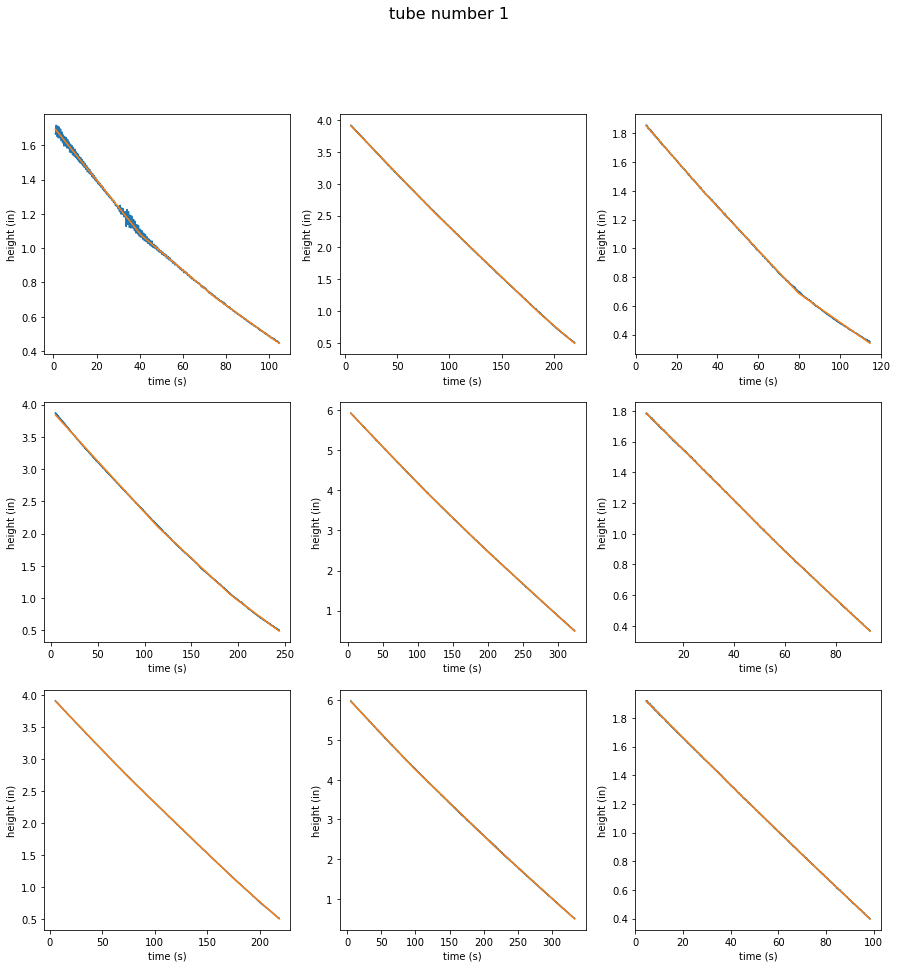

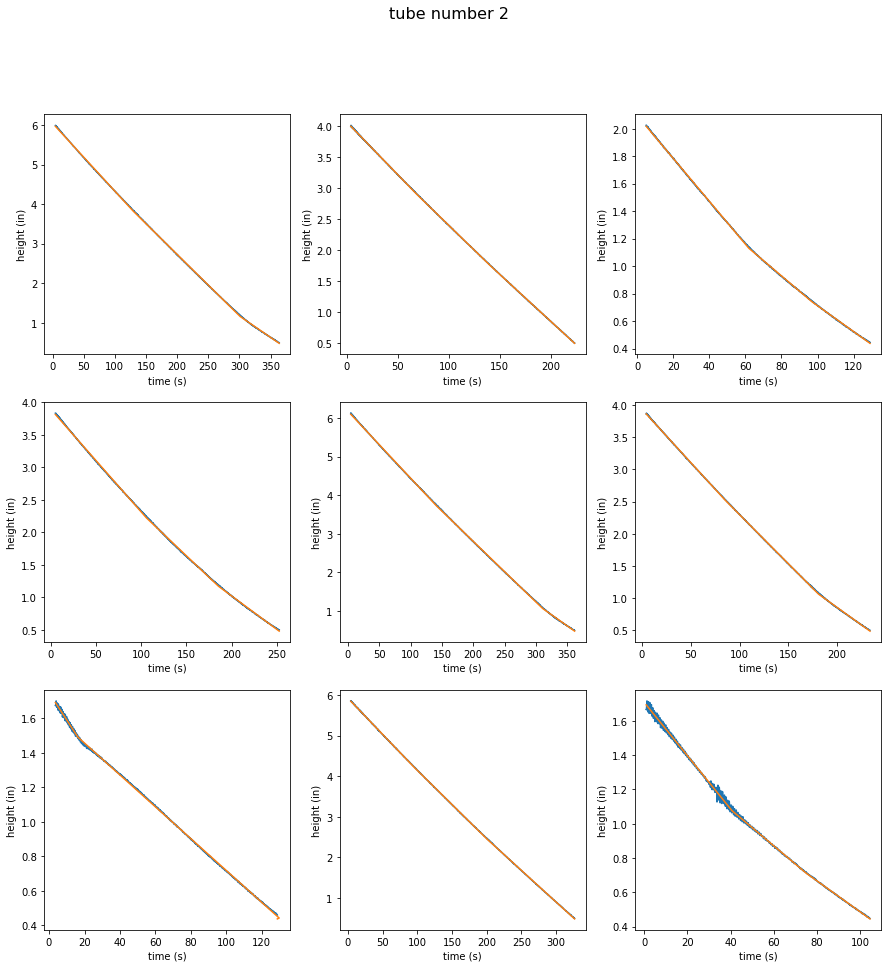

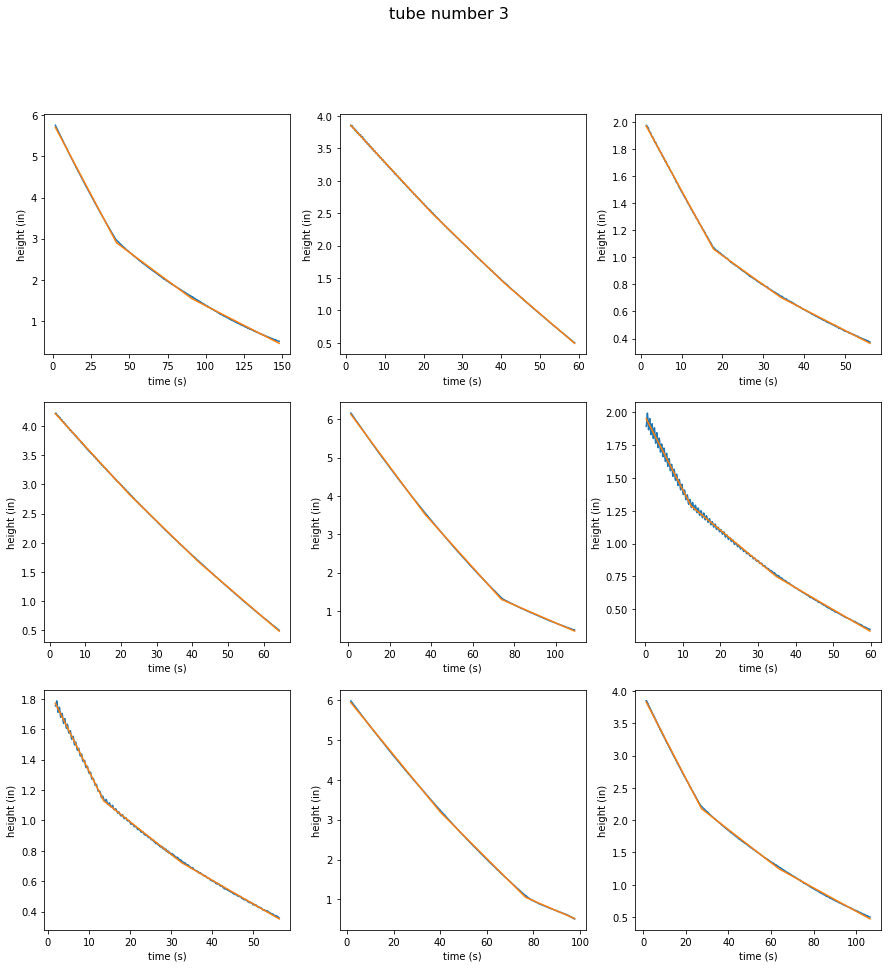

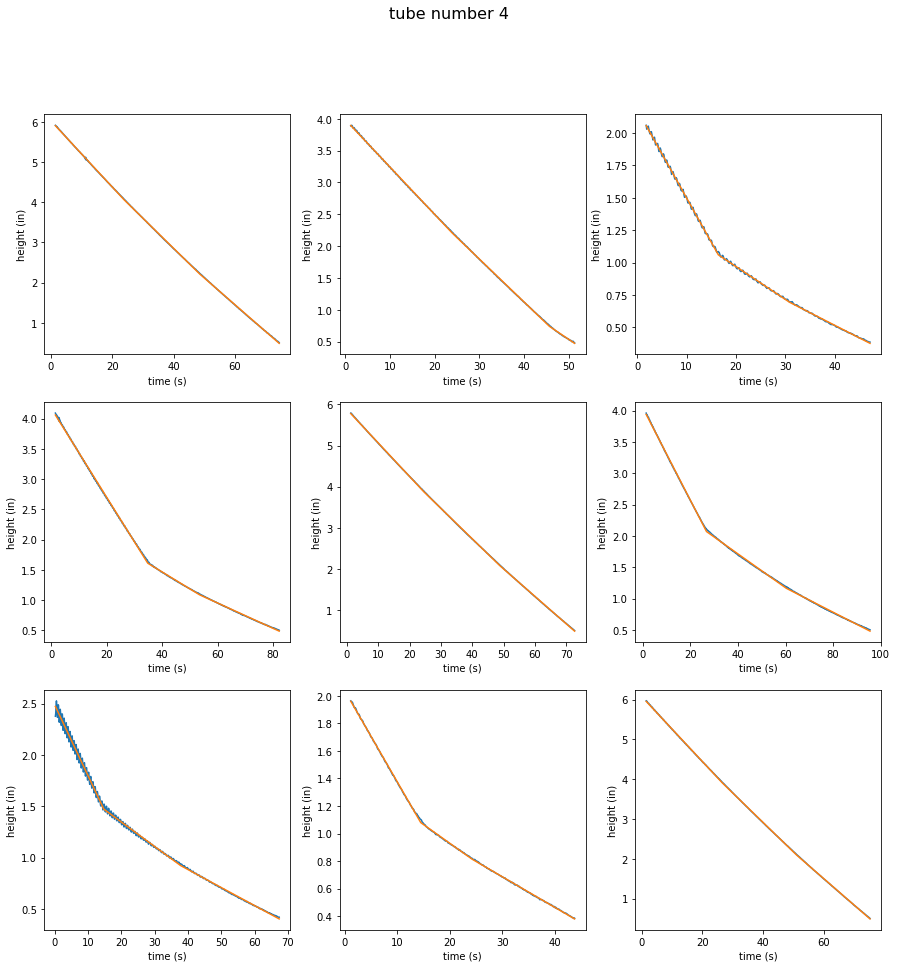

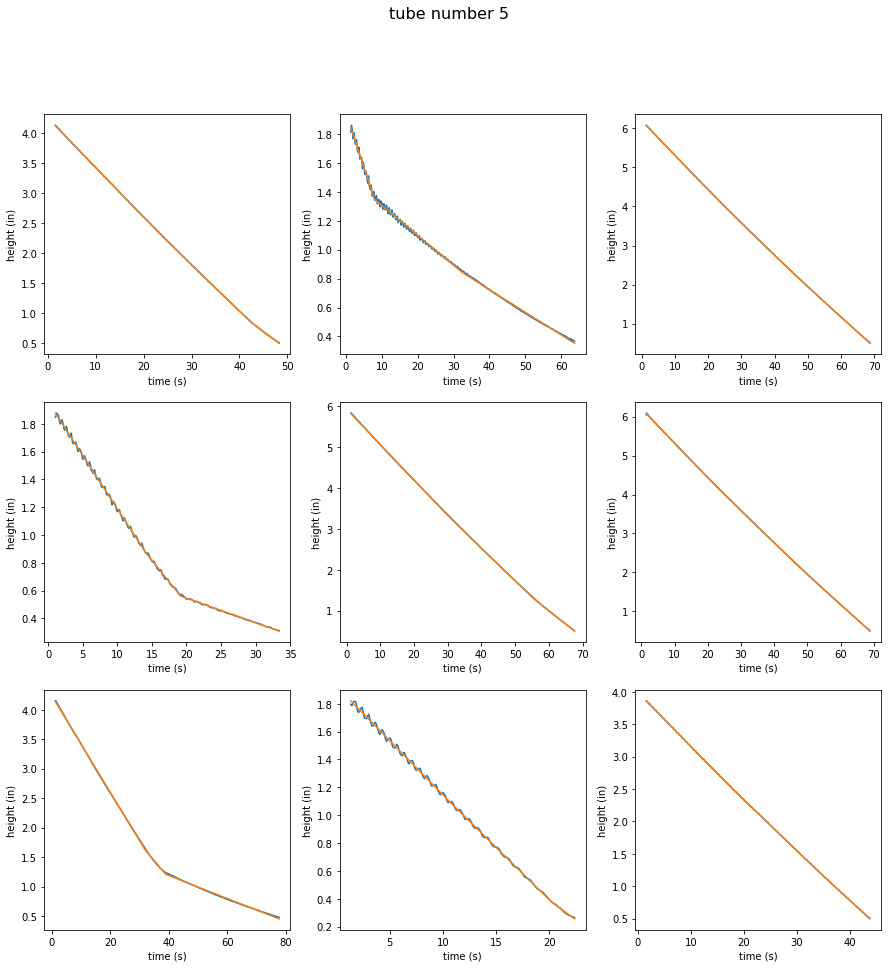

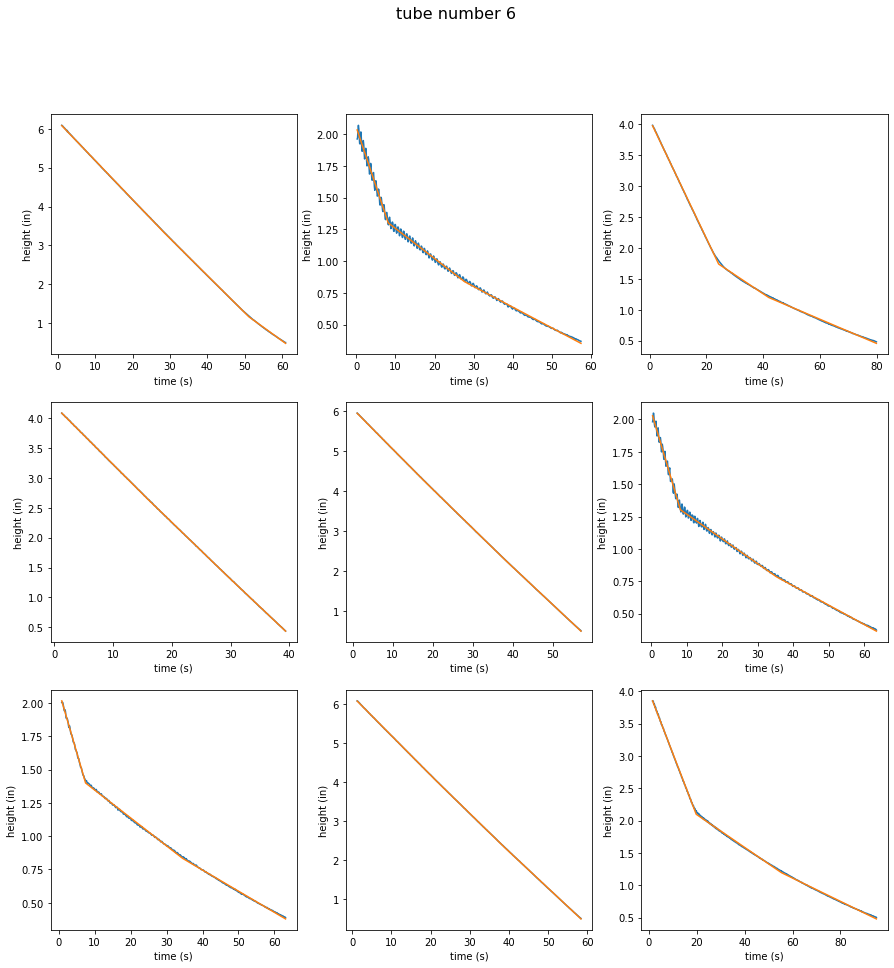

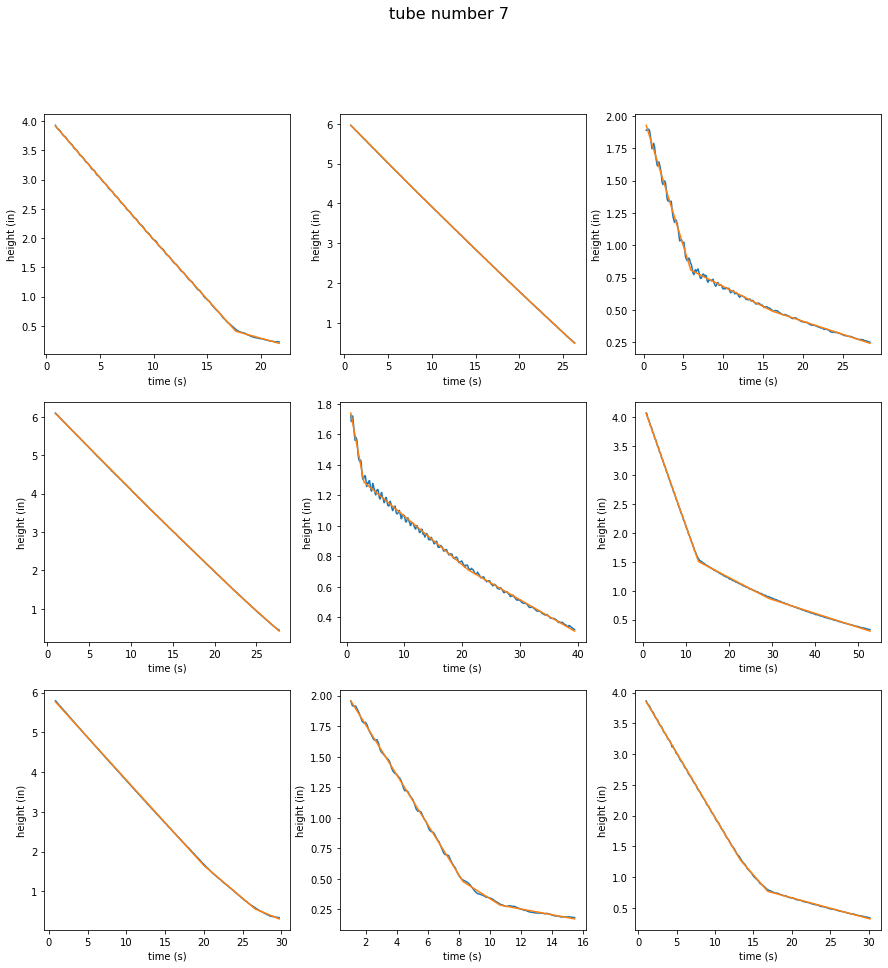

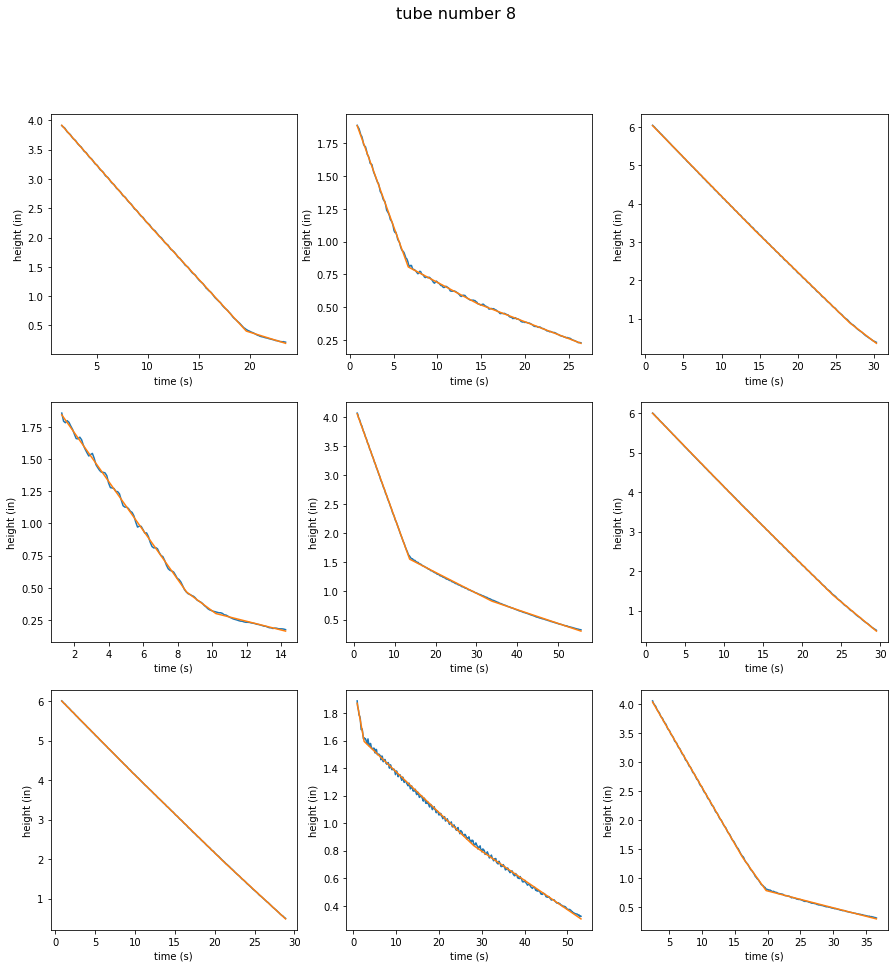

In [5]:
for i in range(0,8):
    fig, ax = plt.subplots(3,3, figsize = (15,15))
    title = "tube number " + str(i+1)
    fig.suptitle(title, fontsize = 16)
    for j in range(0,3):
        for k in range(0,3):
            ex = l[k+3*j+9*i]
            px, py = segments_fit(ex[:,0], ex[:,1], 3) #piecewise linear with 3 knots.
            ax[j][k].plot(ex[:,0], ex[:,1])
            ax[j][k].plot(px,py)
            ax[j][k].set_xlabel("time (s)")
            ax[j][k].set_ylabel("height (in)")

In [9]:
lMesh = []
for k in range(3,8):
    for i in range(1,4):
        for j in range (1,4):
            docString = "groupDrun" + str(i) + "tube" + str(k) + "mesh" + str(j) + ".txt"
            dl = np.loadtxt(docString)
            lMesh.append(dl)

In [10]:
for i in range(0,45):
    ex = lMesh[i]
    ex[:,0] = ex[:,0]-ex[0,0]
    if(ex[-1,1] > 0.25):
        ex[:,1] = ex[:,1] - 1.8
    for j in range(0, len(ex)):
        if (ex[j,1] < ex[0,1] -0.075): # this is to cut off any lag in the beginning
            ex = ex[j:,:] #keep everything afterward
            break
    for j in range(int(len(ex)*3/4), len(ex)):
        if(ex[j,1] < 0.5): # we chose this number because our data does not seem acurate past this
            ex = ex[:j,:]
            break
    lMesh[i] = ex

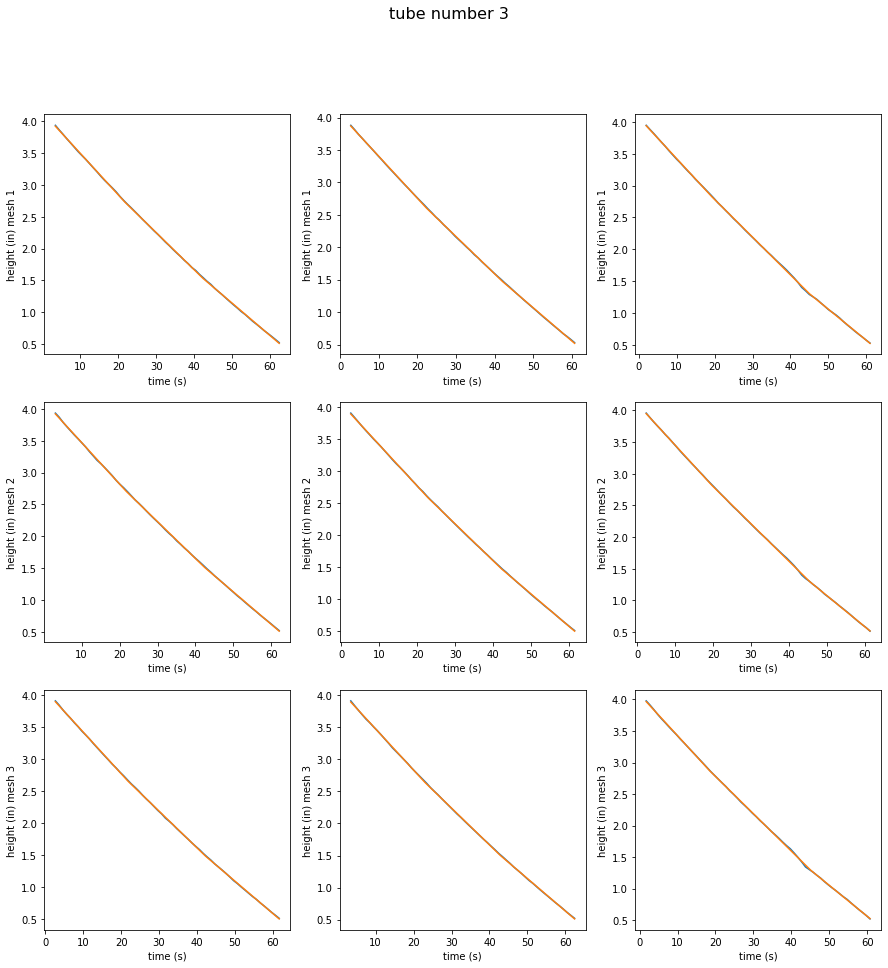

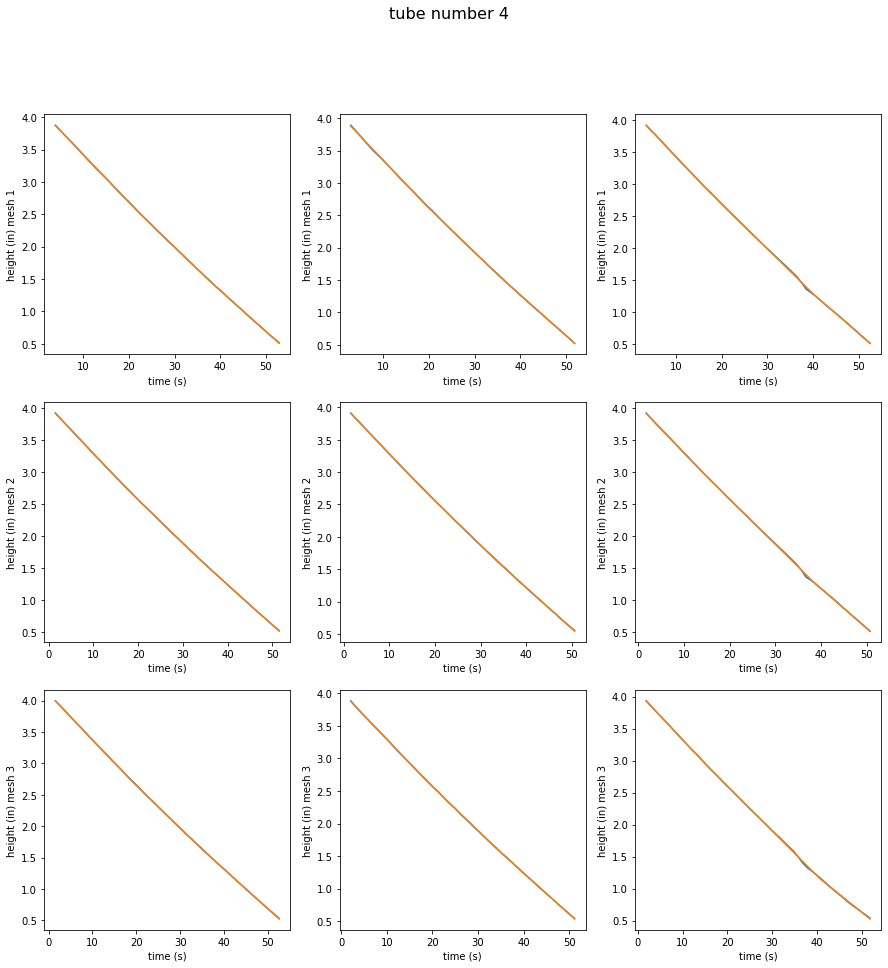

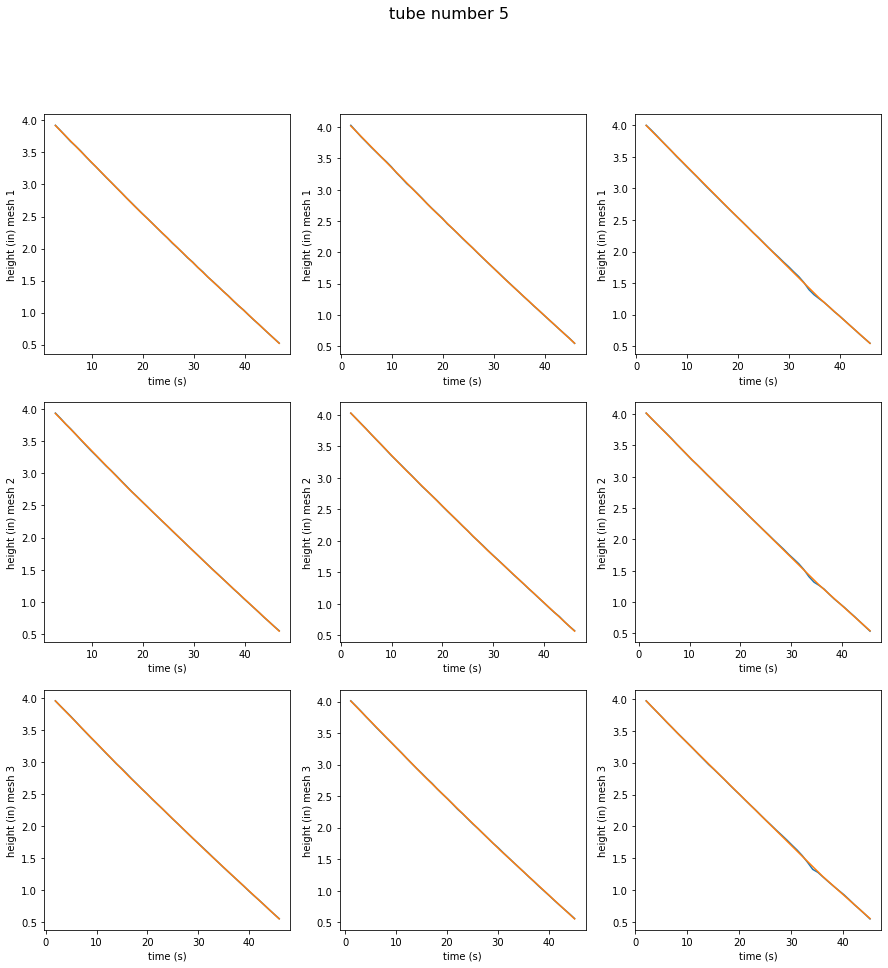

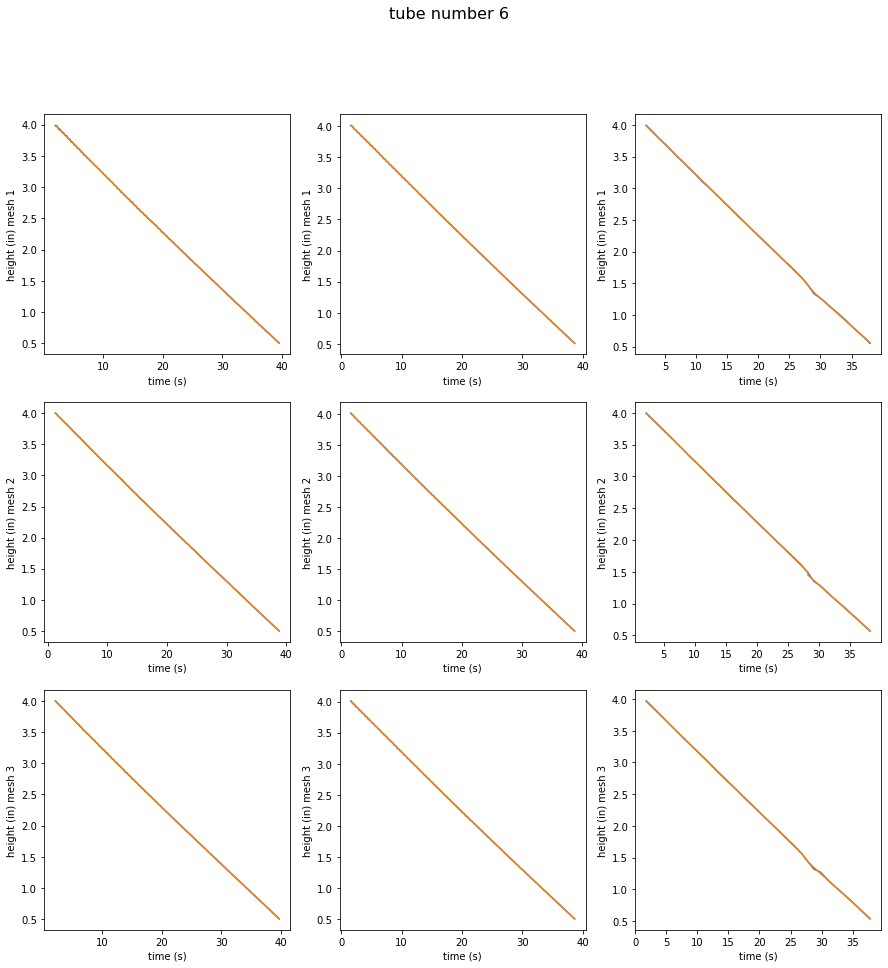

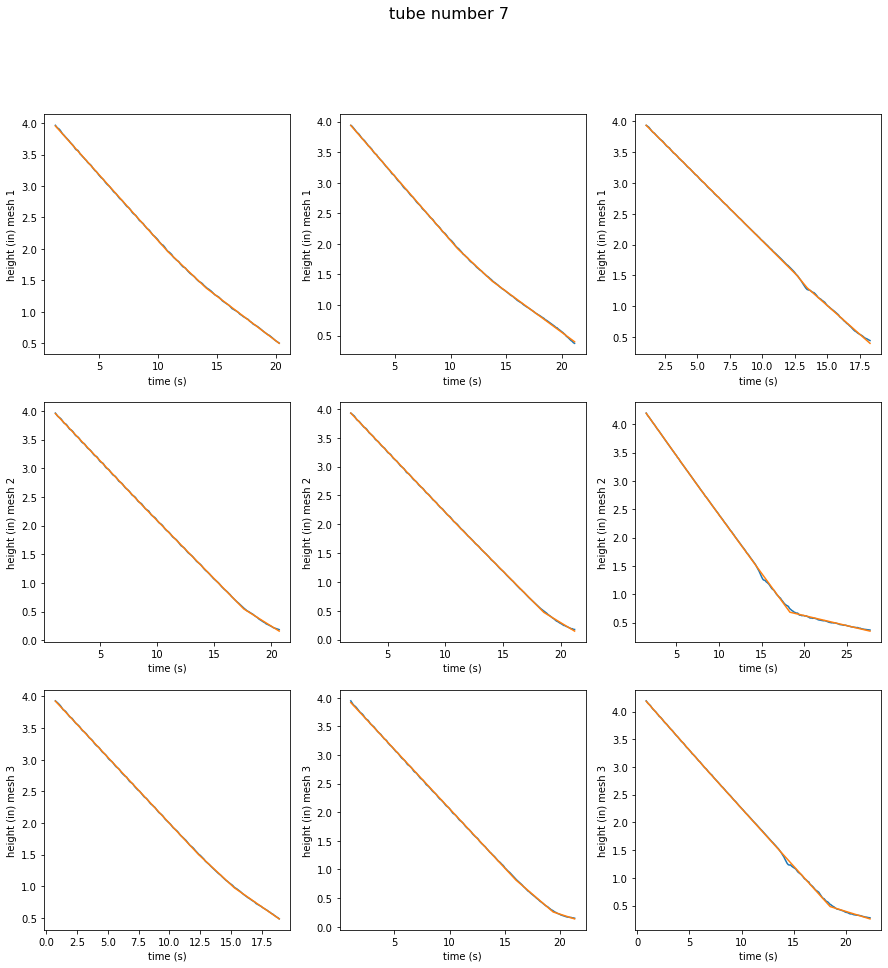

In [11]:
for i in range(0,5):
    fig, ax = plt.subplots(3,3, figsize = (15,15))
    title = "tube number " + str(i+3)
    fig.suptitle(title, fontsize = 16)
    for j in range(0,3):
        for k in range(0,3):
            ex = lMesh[k+3*j+9*i]
            px, py = segments_fit(ex[:,0], ex[:,1], 3) #piecewise linear with 3 knots.
            ax[j][k].plot(ex[:,0], ex[:,1])
            ax[j][k].plot(px,py)
            ax[j][k].set_xlabel("time (s)")
            ax[j][k].set_ylabel("height (in) mesh " + str(j+1))

In [12]:
#Now find the slopes of the line segments
lSlopes = []
for i in range(0,72):
    ex = l[i]
    px, py = segments_fit(ex[:,0], ex[:,1], 3)
    lSlopes.append((py[1:]-py[:-1])/(px[1:]-px[:-1]))

In [13]:
lMeshSlopes = []
for i in range(0,45):
    ex = lMesh[i]
    px, py = segments_fit(ex[:,0], ex[:,1], 3)
    lMeshSlopes.append((py[1:]-py[:-1])/(px[1:]-px[:-1]))

In [14]:
#Now we will look for events. We will consider an event any time the slope from one line to the next changes by
#more than 35%
lEvents = np.zeros(72)
for i in range(0,72):
    ex = lSlopes[i]
    tem = abs(ex[1:]-ex[:-1])/abs(ex[:-1])
    if max(tem > 0.35):
        lEvents[i] = 1

In [15]:
lMeshEvents = np.zeros(45)
for i in range(0,45):
    ex = lMeshSlopes[i]
    tem = abs(ex[1:]-ex[:-1])/abs(ex[:-1])
    if max(tem > 0.35):
        lMeshEvents[i] = 1

In [16]:
tankD = 10 #tank diameter in inches
epsilon = 4.2e-6 #roughness factor
pipeD = np.array([0.156, 0.158, 0.3, 0.308, 0.308, 0.31, 0.4325, 0.435]) #diameter in inches
pipeL = np.array([12,12,3,6,12,24,24,24]) #length in inches
g = 386.09 #gravity in/s^2

model 1 is as follows:
$$\frac{-D^2}{d^2 \cdot \sqrt{2g}} \cdot (2 \cdot \sqrt{H_i+L}-2 \cdot \sqrt{H_f+L})$$

In [21]:
def model1(D,d,g,H,L):
    return((D**2/np.sqrt(2*g))/d**2 * (2*np.sqrt(H+L) - 2*np.sqrt(0.5+L)))

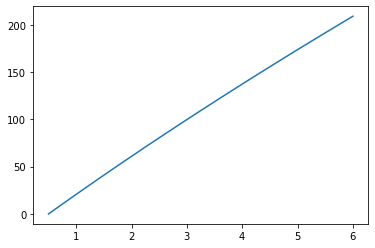

In [27]:
h = np.linspace(0.5,6,101)
t = model1(tankD,pipeD[0],g,h,pipeL[0])
plt.plot(h,t)

In [114]:
k = 1.5 #factor for sudden contraction might need to add 1 for the venting

model 2 is as follows:
$$t_f = \frac{-D^2}{d^2 \cdot \sqrt{\frac{g}{1/2+k/2g}}} \cdot 2 \cdot (\sqrt{H_i+L}-\sqrt{H_f+L})$$

In [25]:
def model2(D,d,g,H,L,k):
    return(D**2/(d**2*np.sqrt(g/(1/2+k/2/g))) * 2 * (np.sqrt(H+L) - np.sqrt(0.5+L)))

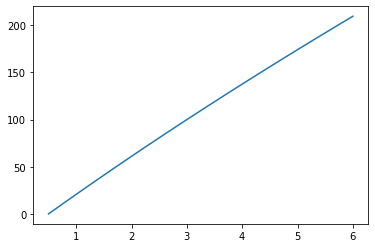

In [26]:
h = np.linspace(0.5,6,101)
t = model2(tankD,pipeD[0],g,h,pipeL[0],k)
plt.plot(h,t)

In [118]:
rho = 1.94 #slug/ft^3
mu = 2.3e-5 #lb s/ft

In [119]:
def reynolds(rho,v,L,mu):
    return(rho*v*L/mu)

In [117]:
def churchill(rho,v,L,mu,epsilon,d): #https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae
    re = reynolds(rho,v,L,mu)
    theta1 = (-2.457*np.log((0.7/re)**0.9 + 0.27*epsilon/d))**16
    theta2 = (37530/re)**16
    return(8*((8/re)**12 + 1/(theta1+theta2)**1.5)**(1/12)) #return friction factor